# CNN pour la classification d'insectes
Ce notebook implémente un modèle simple de CNN pour classer les insectes à partir des images cropped.

In [1]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import seaborn as sns

In [2]:
# 📁 Filepaths and constants
IMAGE_DIR = "cropped/"  
MASK_DIR = "cropped/masks/"
IMAGE_SIZE = (64, 64)    
NUM_CHANNELS = 3  #RGB  

In [7]:
# 📥 Images and labels loading
def load_images_and_labels(df, image_column='ID', label_column='bug type', label_column2 = "reduced_bug_type"):
    X, y, y_red = [], [], []
    for _, row in df.iterrows():
        path = os.path.join(IMAGE_DIR, f"cropped_image_{row[image_column]}.png")
        if os.path.exists(path):
            img = imread(path)
            img_resized = resize(img, IMAGE_SIZE, preserve_range=True, anti_aliasing=True).astype(np.uint8)
            if img_resized.ndim == 2:
                img_resized = np.stack([img_resized]*3, axis=-1)
            X.append(img_resized)
            y.append(row[label_column])
            y_red.append(row[label_column2])
    return np.array(X), np.array(y), np.array(y_red)

In [10]:
# Loading dataframe from images and xlsx file
df_labels = pd.read_excel('classif.xlsx') 
df_labels["reduced_bug_type"] = df_labels["bug type"].apply(lambda x: x if x in ["Bee", "Bumblebee"] else "other")
X, y, y_red = load_images_and_labels(df_labels)

In [26]:
# Encoding labels
le = LabelEncoder()
le_red = LabelEncoder()

y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

y_red_encoded = le_red.fit_transform(y_red)
y_red_cat = to_categorical(y_red_encoded)

# Normalisation
X = X.astype("float32") / 255.0

# Split 
indices = np.arange(len(X))
_, _, idx_train, idx_val = train_test_split(X, indices, test_size=0.2, random_state=42)

X_train = X[idx_train]
X_val = X[idx_val]
y_train = y_cat[idx_train]
y_val = y_cat[idx_val]
y_train2 = y_red_cat[idx_train]
y_val2 = y_red_cat[idx_val]

# Vérif
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("y_train2:", y_train2.shape)
print("Classes bug_type:", np.unique(np.argmax(y_train, axis=1), return_counts=True))
print("Classes bug_type_reduced:", np.unique(np.argmax(y_train2, axis=1), return_counts=True))

X_train: (199, 64, 64, 3)
y_train: (199, 6)
y_train2: (199, 3)
Classes bug_type: (array([0, 1, 2, 3, 4, 5]), array([85, 85, 13,  1,  7,  8]))
Classes bug_type_reduced: (array([0, 1, 2]), array([85, 85, 29]))


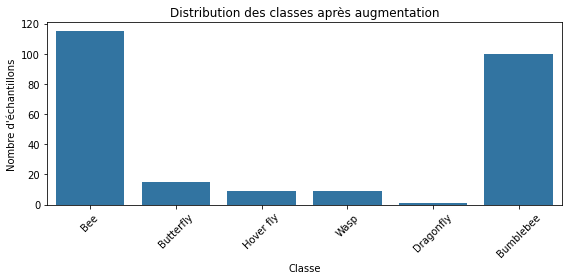

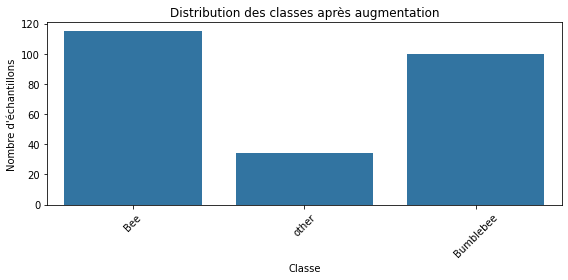

In [27]:
# Display distribution of classes
# Useful if pre data augmentation applied
labels_augmented = np.argmax(y_cat, axis=1)
label_names = le.inverse_transform(labels_augmented)

labels_augmented = np.argmax(y_red_cat, axis=1)
label_names2 = le_red.inverse_transform(labels_augmented)

for labels in [label_names, label_names2]:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=labels)
    plt.title("Distribution des classes après augmentation")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'échantillons")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [29]:
# 🧠 CNN model
model = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model2 = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_red_cat.shape[1], activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,926 (6.20 MB)

 Trainable params: 1,625,926 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,539 (6.20 MB)

 Trainable params: 1,625,539 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

Epoch 1/30


c:\Program Files\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3556 - loss: 1.7246 - val_accuracy: 0.3000 - val_loss: 1.1797
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4456 - loss: 1.2237 - val_accuracy: 0.3000 - val_loss: 1.0869
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4170 - loss: 1.2055 - val_accuracy: 0.3000 - val_loss: 1.2119
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4030 - loss: 1.2032 - val_accuracy: 0.3000 - val_loss: 1.1369
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3900 - loss: 1.1795 - val_accuracy: 0.6000 - val_loss: 1.0637
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4169 - loss: 1.2320 - val_accuracy: 0.6000 - val_loss: 1.0755
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3463 - loss: 1.1991 - val_accuracy: 0.6000 - val_loss: 1.0801
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4627 - loss: 1.1648 - val_accuracy: 0.6000 - val_loss: 1.0997
Epoch 9/30


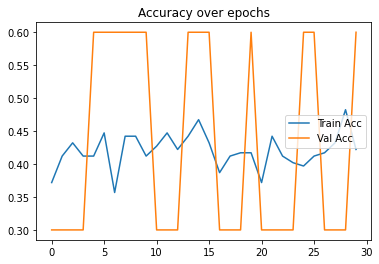

In [31]:
# 🚀 Training

# Callbacks
history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val), 
                    epochs=30, 
                    batch_size=32)

# 📊 Accuracy evolution during training
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.3732 - loss: 1.0772 - val_accuracy: 0.6000 - val_loss: 0.9440
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4185 - loss: 0.9959 - val_accuracy: 0.3000 - val_loss: 0.9812
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4482 - loss: 1.0194 - val_accuracy: 0.3000 - val_loss: 1.0046
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3636 - loss: 1.0338 - val_accuracy: 0.6000 - val_loss: 0.9589
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.3945 - loss: 1.0233 - val_accuracy: 0.6000 - val_loss: 0.9311
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4834 - loss: 1.0011 - val_accuracy: 0.6000 - val_loss: 0.9500
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3761 - loss: 1.0343 - val_accuracy: 0.3000 - val_loss: 0.9893
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4428 - loss: 1.0092 - val_accuracy: 0.3000 - val_loss: 0.9627

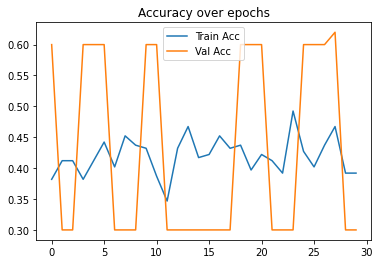

In [32]:
# 🚀 Training

# Callbacks
history2 = model2.fit(data_augmentation.flow(X_train2, y_train2, batch_size=32),
                    validation_data=(X_val2, y_val2), 
                    epochs=30, 
                    batch_size=32)

# 📊 Accuracy evolution during training
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [ ]:
# 📊 Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8383 - loss: 0.6305
Validation Accuracy: 0.820


In [ ]:
# Prediction on valitation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)
print(np.bincount(y_true_classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[30 15  2  0  2  1]


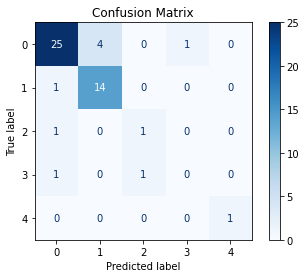

In [ ]:
# 📈 Confusion matrice
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()